Import any packages that might be useful

In [1]:
import torch
import glob
import argparse
import os
import numpy as np
import pickle
import sys
from tqdm import tqdm
import random
import json
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition import ExpectedImprovement

Load latent vector x and corresponding property y

define some functions

evalnum->initial points number (2)

inibest->initial previous best for expected improvement computation

In [2]:
filelist = glob.glob('*.npy')
plistini=np.loadtxt('property2000.txt')
lvlistini=[]
lvlist=[]
plist=[]
evalnum=2
inibest=-9999

def findmax(xlist):
    maxv=-999
    maxid=0
    for i in range(len(xlist)):
        if xlist[i]>maxv:
            maxv=xlist[i]
            maxid=i
    return maxv

data extraction and format conversion (from 'list' to 'tensor')

X_ini_list->evaluated vectors

X_eval_list->unevaluated vectors

In [3]:
for filename in tqdm(filelist):
    lv = np.array(json.load(open(filename))['encode'])
    lvlistini.append(lv)
for i in range (2000):
    lvmean=lvlistini[i].reshape(1000)[:500]
    lvlist.append(lvmean)
    plist.append(-plistini[i].reshape(1))
X_ini_list=lvlist[342:344]
Y_ini_list=plist[342:344]
X_eval_list=lvlist[:342]+lvlist[344:]
Y_eval_list=plist[:342]+plist[344:]



100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1224.77it/s]


Main loop of Bayesian optimization with BOtorch:
1. Build a GP model with the data in X_ini_list and Y_ini_list.
2. Calculate exact marginal log likelihood function for this GP model.
3. Maximize the marginal log likelihood function to get optimized parameters.
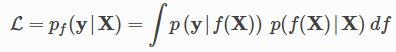
4. Use acquisition function to find the next evaluation point.
5. Put the new evaluated point and corresponding property back to X_ini_list and Y_ini_list

Basically, the optimization process is different from a normal BO process. During this procedure, the posterior is updated by doing the marginal likelihood optimization, not by bayesian rule. I'm not sure which way is more efficient. The acquisition funtion I'm using now is still expected improvement, since I also used EI for TPE. UCB is just a back up method for code testing.

In [4]:
#main
# 1998 comes from 2000-evalnum(initial, which is 2)
for i in range(1998):

    X_ini = torch.FloatTensor(np.array(X_ini_list))
    Y_ini = torch.FloatTensor(np.array(Y_ini_list))
    X_eval = torch.FloatTensor(np.array(X_eval_list))
    Y_eval = torch.FloatTensor(np.array(Y_eval_list))
    gp = SingleTaskGP(X_ini, Y_ini)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll);



#UCB acquisition function, need to check beta value later
    UCB = UpperConfidenceBound(gp, beta=0.1)
    EI = ExpectedImprovement(gp, best_f=inibest)
    acq_best=-999
    next_eval_point=0
    for j in range (2000-evalnum):
        acq_list=[]
        #print(X_eval[j])
        acq_value=EI(X_eval[j].reshape(1,500))
        acq_list.append(acq_value)
        if acq_best<acq_value:
            acq_best=acq_value
            next_eval_point=j


    X_ini_list.append(X_eval_list.pop(next_eval_point))
    Y_ini_list.append(Y_eval_list.pop(next_eval_point))
    inibest=findmax(Y_ini_list)
    evalnum=evalnum+1
    print(evalnum,-inibest)

'''from botorch.optim import optimize_acqf
from botorch.utils.sampling import manual_seed

#range can be shrinked
bounds = torch.stack([-torch.ones(500), torch.ones(500)])
'''


#not sure about the how they select raw_samples
'''candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=1, raw_samples=2,
)
candidate, acq_value = optimize_acqf(
    acq_function=EI, bounds=bounds, q=1, num_restarts=2, raw_samples=100
)'''

'''candidates, acq_value = optimize_acqf(
        acq_function=EI, bounds=bounds, q=2, num_restarts=2, raw_samples=100
    )'''

#print(acq_value)









3 [-1.01534]
4 [-1.01534]
5 [-1.01534]
6 [-1.01534]
7 [-1.91674133]
8 [-1.91674133]
9 [-1.91674133]
10 [-1.91674133]
11 [-1.91674133]
12 [-1.91674133]
13 [-1.91674133]
14 [-1.91674133]
15 [-1.91674133]
16 [-2.18209812]
17 [-2.18209812]
18 [-2.18209812]
19 [-2.18209812]
20 [-2.18209812]
21 [-2.18209812]
22 [-2.66720333]
23 [-2.66720333]
24 [-2.66720333]
25 [-2.66720333]
26 [-2.66720333]
27 [-2.66720333]
28 [-2.66720333]
29 [-2.66720333]
30 [-2.66720333]
31 [-2.66720333]
32 [-2.66720333]
33 [-2.66720333]
34 [-2.66720333]
35 [-2.66720333]
36 [-2.66720333]
37 [-2.66720333]
38 [-2.66720333]
39 [-2.66720333]
40 [-2.66720333]
41 [-2.66720333]
42 [-2.66720333]
43 [-2.66720333]
44 [-2.66720333]
45 [-2.66720333]
46 [-2.66720333]
47 [-2.66720333]


KeyboardInterrupt: 

This method actually works pretty well. I used the same initial sets I used before to do the test. It turns out in all of these 5 cases, we only need less than 30 steps to find the vector with minimum energy. In case these five are the lucky cases, I also tried some other random initial sets. It still takes less than 30 steps to find the minimum. Also the computation is fast, I can finish these tests on my own desktop.

There might be a potential problem however:

After 586 times run, there will be an error says "Matrix not positive definite after repeatedly adding jitter up to {jitter_new:.1e}. " Fortunately we don't need that many steps to find the minimum.

This is a figure of the average minimum value at each step. We can see this GP surrogate model has much better performance than the other methods.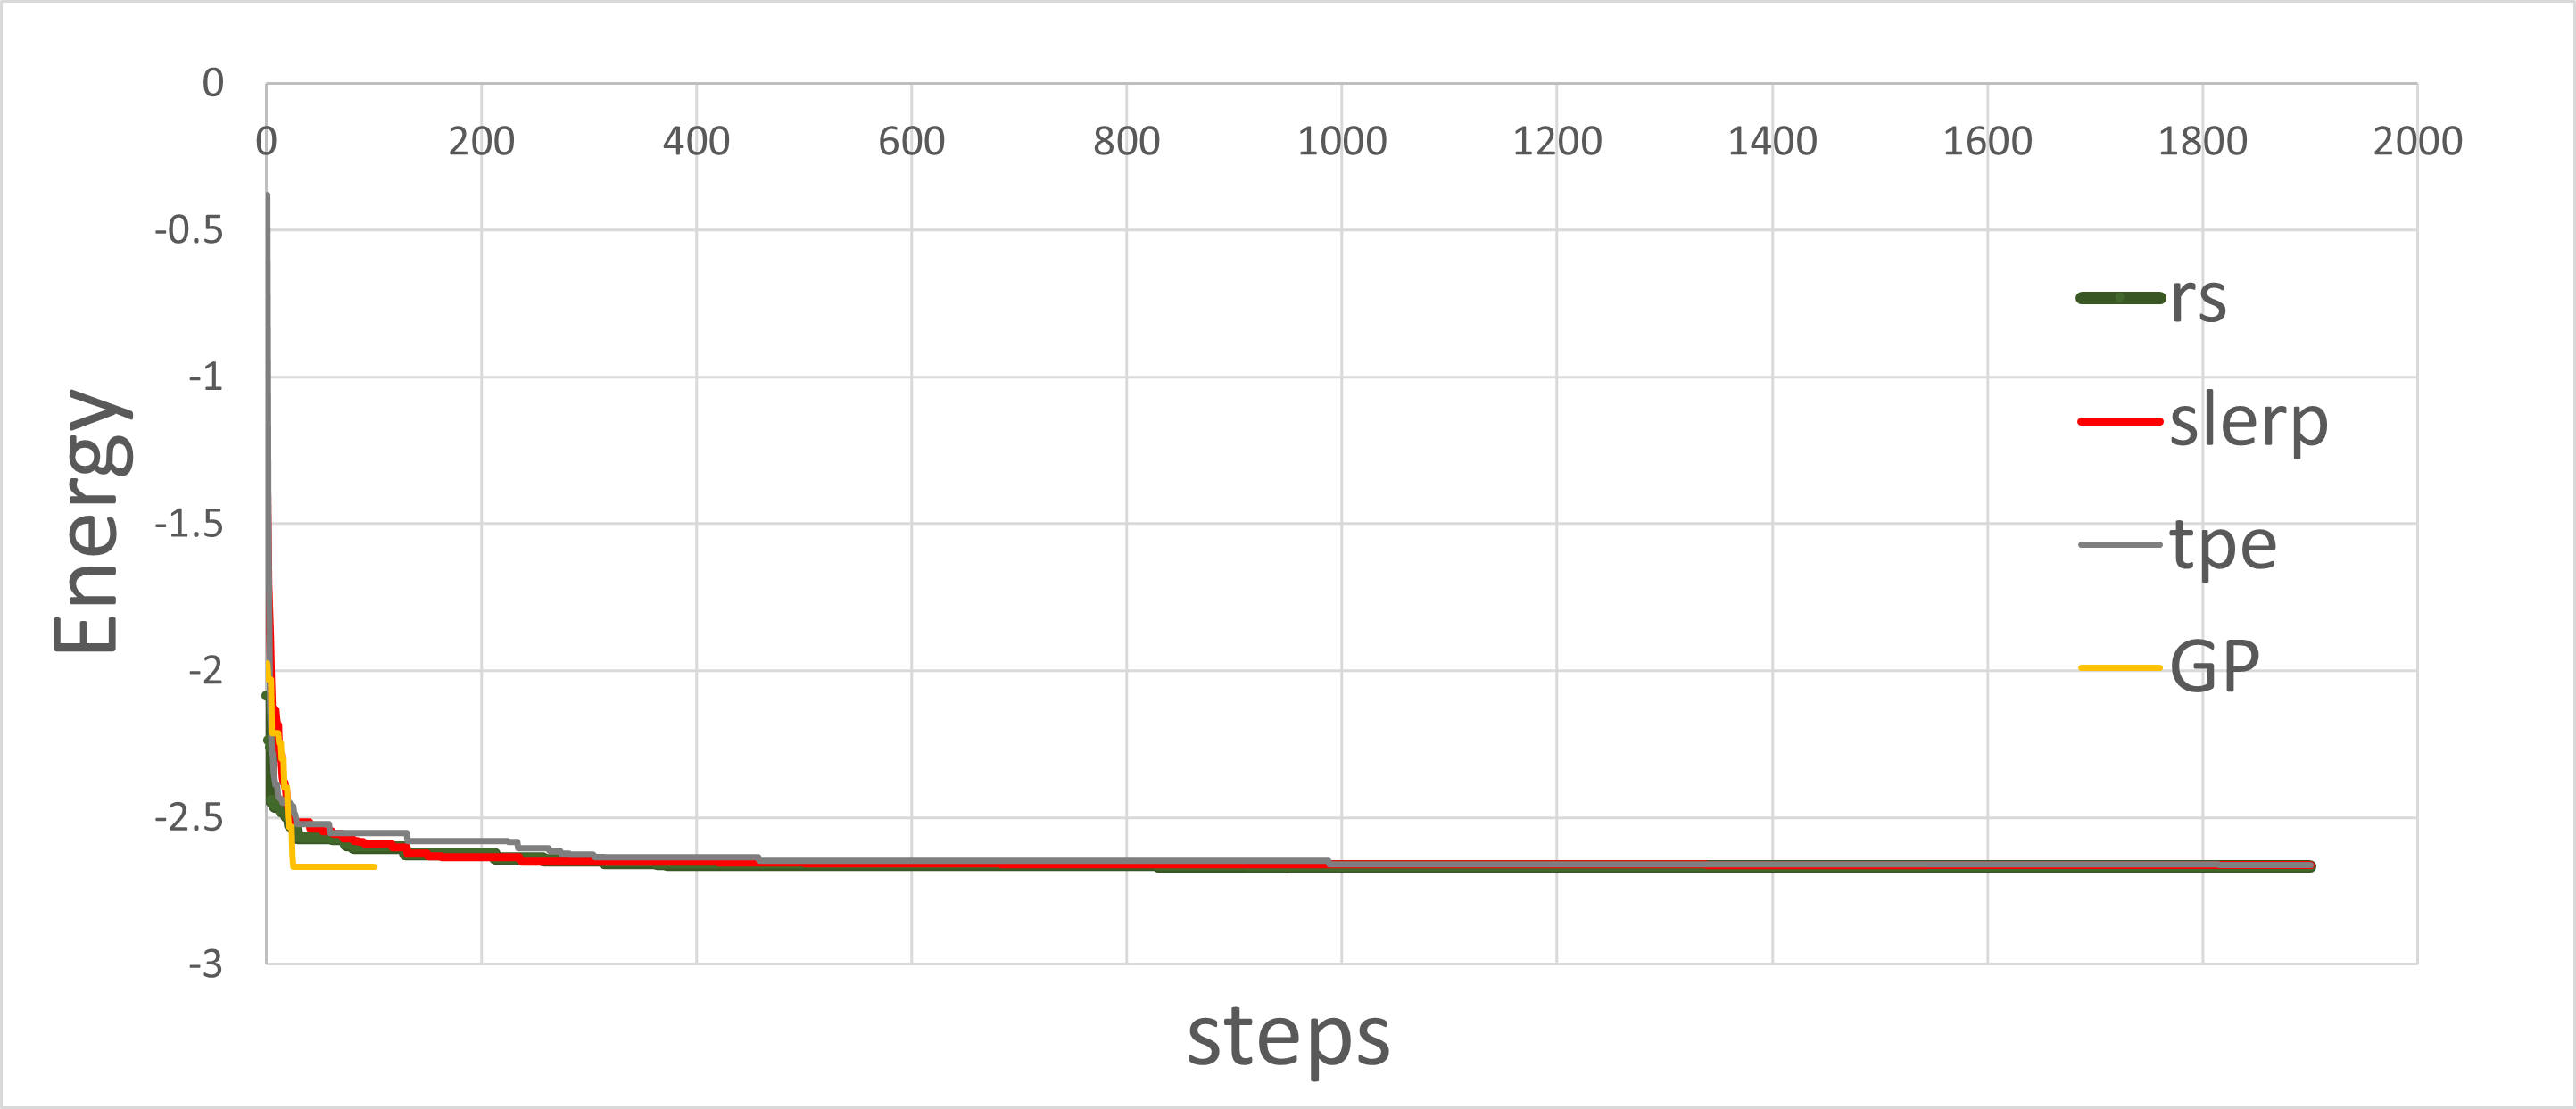


I'm still thinking if it's necessary for us to do bayesian optimization by updating the posterior with the functions, or these two methods are just basically the same thing?

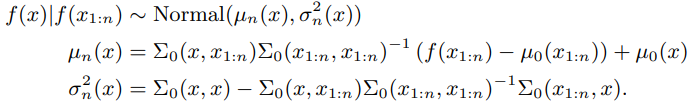